## Stat154 - Homework Assignment 1

## Collaborators: Pramod Mitikiri, Daniel Kjeldsen, Jeppe Blomgren, Julius Ritter

In this assignment, we aim to predict whether breast cancer patients have "high survival" or "low survival" based on their unique gene expression profiles.

# 1A) EDA

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

mrna_org = pd.read_table("data_mrna_agilent_microarray.txt")
clinical_org = pd.read_table("brca_metabric_clinical_data.tsv")

Some initial box plots showcase the correlation between the treatment of a patient and their overall survival months. From these graphs, it is clear that the type of treatment has an impact on the overall survival rate of the patient.

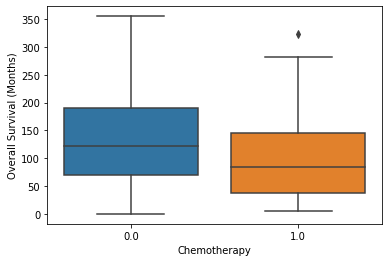

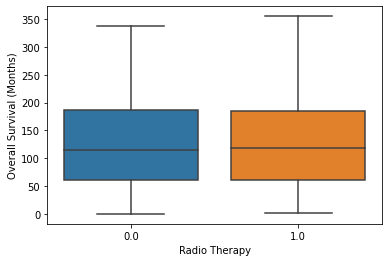

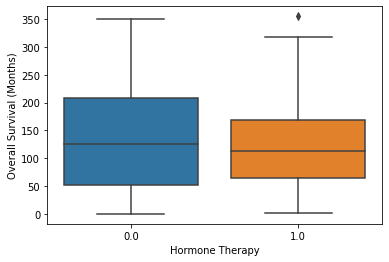

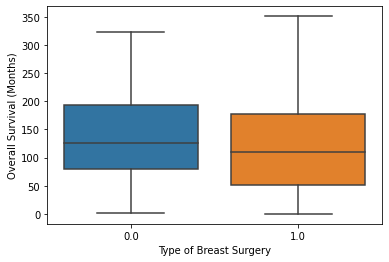

In [7]:
clinical_org['Chemotherapy'] = clinical_org['Chemotherapy'].map({'YES':1 ,'NO':0})
clinical_org['Radio Therapy'] = clinical_org['Radio Therapy'].map({'YES':1 ,'NO':0})
clinical_org['Hormone Therapy'] = clinical_org['Hormone Therapy'].map({'YES':1 ,'NO':0})
clinical_org['Type of Breast Surgery'] = clinical_org['Type of Breast Surgery'].map({'MASTECTOMY':1 ,'BREAST CONSERVING':0})

sns.boxplot(x="Chemotherapy", y="Overall Survival (Months)", data=clinical_org)
plt.show()
sns.boxplot(x="Radio Therapy", y="Overall Survival (Months)", data=clinical_org)
plt.show()
sns.boxplot(x="Hormone Therapy", y="Overall Survival (Months)", data=clinical_org)
plt.show()
sns.boxplot(x="Type of Breast Surgery", y="Overall Survival (Months)", data=clinical_org)
plt.show()

We found the average number of survival months for each age group. The resulting graph expectedly shows a big difference in the survival months for difference age groups, which shows that it might not make sense to compare people with a large age gap with each other.

<AxesSubplot: xlabel='Age Range'>

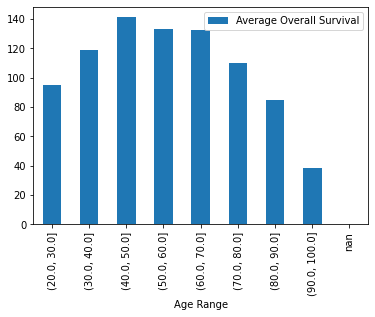

In [8]:
clinical_org_age_bins = pd.cut(x=clinical_org["Age at Diagnosis"], bins=[10,20,30,40,50,60,70,80,90,100])
co_age_divided = clinical_org.copy()
co_age_divided["Age Range"] = clinical_org_age_bins
co_age_divided = co_age_divided[["Age Range", "Overall Survival (Months)"]]
bins = co_age_divided[["Age Range"]].drop_duplicates().sort_values(by="Age Range").reset_index()
for i in range(len(bins)):
    bins.loc[i, "Average Overall Survival"] = co_age_divided[co_age_divided["Age Range"] == bins.loc[i, "Age Range"]]["Overall Survival (Months)"].mean()
bins.plot.bar(x="Age Range", y="Average Overall Survival")

We also looked at the correlation between the tumor size and the survival months, but it did not seem like there was any particular link. From the scatter plot it can be seen that a small tumor is more normal, but it does not really affect the survival months. 

/home/jfb/.conda/envs/mad/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='Tumor Size', ylabel='Overall Survival (Months)'>

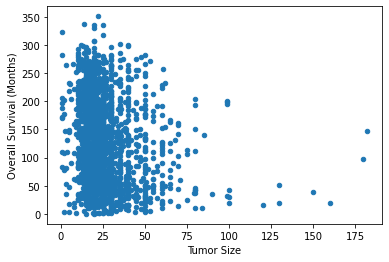

In [9]:
clinical_org.plot.scatter(x="Tumor Size", y="Overall Survival (Months)")

# 2) Data Cleaning

In the next step, we create unique names since we expect some genes to be listed twice.

In [10]:
from collections import Counter

def make_unique(names):
    name_freq = Counter()
    unique_names = []
    for name in names:
        name_freq[name] += 1
        unique_names.append(name if name_freq[name] == 1 else f"{name}-{name_freq[name]}")
    return unique_names

mrna = mrna_org.T
mrna.drop(["Entrez_Gene_Id"], inplace=True)
mrna.dropna(axis='columns', inplace=True)

mrna.columns = make_unique(mrna.iloc[0])
mrna.drop(["Hugo_Symbol"], inplace=True)

Now, we sort the the genes by variance and only keep the first 5000 values, since a higher variance expresses a greater correlation and greater expressive capability with regards to breast cancer and it would also be too expensive to run a test on all ~20,000 genes.

In [11]:
mrna_var = mrna.var()
var_cutoff = mrna_var.sort_values(ascending=False)[5000]
to_drop = (mrna_var < var_cutoff)
mrna.drop(columns=to_drop[to_drop].index, inplace=True)

Moreover, we discovered 530 samples with "NA"-values in their overall survival months which we thus have to omit from our sample.

In [12]:
clinical_org.set_index("Patient ID", inplace=True)
clinical_org.dropna(subset=["Overall Survival (Months)"], inplace=True)

# 1B) Binarization

Reflecting on our binarization process, we had two possibilities in mind: Either focus on an absolute threshold for "low survival" vs. "high survival" or using percentiles. In cancer research, if a patient still lives more than five years after the diagnosis, they are considered as "survived". However, this turned out to be a disproportionately large portion of our data set. Therefore, we used percentages of the dataset and kept the bottom and top quantile (top 25% and bottom 25%) while dropping the middle 50% of the data. However, to account for the people who are still alive but classified as "low survival" and thus need to be discarded, we increased the lower bound to 35%. Having said that, we would like to note that playing with the percentages (top and bottom 33% or 20%) did not enhance the predictive ability of our model noticeably.

In [13]:
LOW_SURVIVAL_QUANTILE = 0.35 # low survival quantile is bigger to account for living people getting discarded 
HIGH_SURVIVAL_QUANTILE = 0.75

def get_labels(clinical_org):
    labels = pd.qcut(clinical_org["Overall Survival (Months)"], [0, LOW_SURVIVAL_QUANTILE, HIGH_SURVIVAL_QUANTILE, 1], labels=[0, -1, 1])
    labels.drop(labels[labels == -1].index, inplace=True)

    labels.drop(labels[labels == 0].index.intersection(clinical_org[(clinical_org["Patient's Vital Status"] == "Living") | (clinical_org["Patient's Vital Status"] == "Died of Other Causes")].index), inplace=True)
    labels = labels[labels.index.intersection(mrna.index)]
    return labels

We removed any patient who has had any form of Therapy (since a Chemotherapy could have unforeseeable impacts on the gene interaction. Furthermore, by creating various age groups, we separated older people who are naturally weaker in case of any lilness/disease from younger patients.  We noticed that the biggest impact on our dataset was achieved by altering the age cutoff.

In [14]:
from itertools import product

labels = []
permuts = {"Chemotherapy": [0],
           "Hormone Therapy": [0],
           "Radio Therapy": [0]}

AGE_START = 25
AGE_END = 95
AGE_INTERVAL = 10
MIN_GROUP_SIZE = 10

for permut in [dict(zip(permuts, v)) for v in product(*permuts.values())]:
    patients = clinical_org
    for key, value in permut.items():
        patients = patients[patients[key] == value]
        
    for age_cutoff in range(AGE_START, AGE_END - AGE_INTERVAL, AGE_INTERVAL):
        patients_age = patients[(patients['Age at Diagnosis'] >= age_cutoff) & (patients['Age at Diagnosis'] < age_cutoff + AGE_INTERVAL)]
        
        if len(patients_age) >= MIN_GROUP_SIZE:
            labels.append(get_labels(patients_age))
        
labels = pd.concat(labels).astype('int')

print(f"Class imbalance: {sum(labels == 1) / len(labels)}")

Class imbalance: 0.576


3. 3. Training Models

We adjusted our training set from 90% down to 75% to increase the stability of the outcome as our sample size has decreased to about ~100 patients due to our deliberate data cleaning procedure.

In [15]:
TRAIN_SIZE = 0.75
TEST_SIZE = 1 - TRAIN_SIZE

X = mrna.loc[labels.index]
last_train_idx = int(TRAIN_SIZE * len(X))

X_train = X[:last_train_idx]
X_test = X[last_train_idx:]

Y_train = labels[:last_train_idx]
Y_test = labels[last_train_idx:]

print(f"Class imbalance of training set: {sum(Y_train == 1) / len(Y_train)}")
print(f"Class imbalance of test set: {sum(Y_test == 1) / len(Y_test)}")

Class imbalance of training set: 0.5913978494623656
Class imbalance of test set: 0.53125


We initiate our random forest algorithm and insert different hyper parameter variations, which we evaluate using cross-validation.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier()
params = {'n_estimators': [100, 200, 300],
          'max_features': ['sqrt', 'log2']}

clf = GridSearchCV(rfc, params, verbose=3, cv=5)
clf.fit(X_train, Y_train)

print(f"Best parameters: {clf.best_params_}")
print(f"Accuracy: {sum(clf.best_estimator_.predict(X_test) == Y_test) / len(Y_test)}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] max_features=sqrt, n_estimators=100 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . max_features=sqrt, n_estimators=100, score=0.737, total=   0.3s
[CV] max_features=sqrt, n_estimators=100 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] . max_features=sqrt, n_estimators=100, score=0.737, total=   0.3s
[CV] max_features=sqrt, n_estimators=100 .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] . max_features=sqrt, n_estimators=100, score=0.684, total=   0.3s
[CV] max_features=sqrt, n_estimators=100 .............................
[CV] . max_features=sqrt, n_estimators=100, score=0.611, total=   0.3s
[CV] max_features=sqrt, n_estimators=100 .............................
[CV] . max_features=sqrt, n_estimators=100, score=0.667, total=   0.3s
[CV] max_features=sqrt, n_estimators=200 .............................
[CV] . max_features=sqrt, n_estimators=200, score=0.632, total=   0.5s
[CV] max_features=sqrt, n_estimators=200 .............................
[CV] . max_features=sqrt, n_estimators=200, score=0.632, total=   0.6s
[CV] max_features=sqrt, n_estimators=200 .............................
[CV] . max_features=sqrt, n_estimators=200, score=0.684, total=   0.6s
[CV] max_features=sqrt, n_estimators=200 .............................
[CV] . max_features=sqrt, n_estimators=200, score=0.611, total=   0.6s
[CV] max_features=sqrt, n_estimators=200 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   14.4s finished


Best parameters: {'max_features': 'log2', 'n_estimators': 300}
Accuracy: 0.71875


We now train the iterative random forest. Since our computational power is limited, we reuse the best parameters found from the random forest CV grid search, rather than running a new grid search, which may negatively affect the accuracy of our model.

In [17]:
from irf.ensemble import wrf

irf = wrf(**clf.best_params_)
irf.fit(X_train, Y_train, keep_record=False)

print(f"Accuracy: {sum(irf.predict(X_test) == Y_test) / len(Y_test)}")

Accuracy: 0.65625


# Interrogating Models

To find the most relevant genes, we first plot the impurity decrease in order to find a suitable threshold.

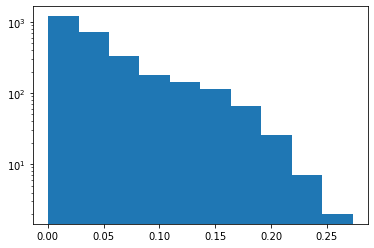

In [18]:
from irf.utils import visualize_impurity_decrease

visualize_impurity_decrease(irf, yscale='log', xscale="linear")

We then find the 4 genes with the highest average impurity decrease in the random forest and plot those, along with the best pair. In the plots below, blue points are "high survival" and red points are "low survival".

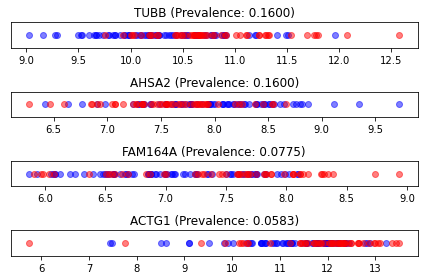

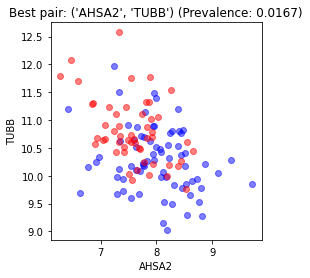

In [19]:
import matplotlib.pyplot as plt
from irf.utils import get_prevalent_interactions

IMPURITY_DECREASE_THRESHOLD = 0.1

prevalence = get_prevalent_interactions(irf, impurity_decrease_threshold=IMPURITY_DECREASE_THRESHOLD)
best_genes = list(sorted(filter(lambda x: len(x[0]) == 1, prevalence.items()), key=lambda x: -x[1]))
best_pair = max(filter(lambda x: len(x[0]) == 2, prevalence.items()), key=lambda x: x[1])

fig, axs = plt.subplots(4, 1)
for i, ax in enumerate(axs.reshape(-1)):
    ax.get_yaxis().set_ticks([])
    ax.set_title(f"{mrna.columns[best_genes[i][0][0]]} (Prevalence: {best_genes[i][1]:.4f})")
    
    x = mrna.iloc[:, best_genes[i][0][0]][labels[labels == 1].index]
    y = np.zeros(len(labels[labels == 1]))
    ax.scatter(x, y, c="blue", alpha=0.5)
    
    x = mrna.iloc[:, best_genes[i][0][0]][labels[labels == 0].index]
    y = np.zeros(len(labels[labels == 0]))
    ax.scatter(x, y, c="red", alpha=0.5)
    
plt.tight_layout()
plt.show()

best_pair_names = (mrna.columns[best_pair[0][0]], mrna.columns[best_pair[0][1]])

fig, ax = plt.subplots()
ax.set_title(f"Best pair: {best_pair_names} (Prevalence: {best_pair[1]:.4f})")
ax.set_xlabel(mrna.columns[best_pair[0][0]])
ax.set_ylabel(mrna.columns[best_pair[0][1]])

x = mrna.iloc[:, best_pair[0][0]][labels[labels == 1].index]
y = mrna.iloc[:, best_pair[0][1]][labels[labels == 1].index]
ax.scatter(x, y, c="blue", alpha=0.5)
x = mrna.iloc[:, best_pair[0][0]][labels[labels == 0].index]
y = mrna.iloc[:, best_pair[0][1]][labels[labels == 0].index]
ax.scatter(x, y, c="red", alpha=0.5)
ax.set_aspect("equal")
plt.show()

Looking at the plots above, it is seen that single genes are much more prevalent in the random forests than any single pair of genes. However, in all 5 plots, we see a fairly clear separation of the two groups of patients, although there is still significant overlap.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dc19fcf8-fcbc-4029-b9cc-903eb0e7b73d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>